## Importing Dependencies and Libraries

In [227]:
from statistics import mean

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

## Features
If you ever need to take a look at the features of this dataset, refer to the following cell

- Name: Name of the Phone
- Brand: Brand Name
- Model: Model of the Phone
- Battery capacity (mAh): Battery capacity in mAh
- Screen size (inches): Screen Size in Inches across opposite corners
- Touchscreen: Whether the phone is touchscreen supported or not
- Resolution x: The resolution of the phone along the width of the screen
- Resolution y: The resolution of the phone along the height of the screen
- Processor: No. of processor cores
- RAM (MB): RAM available in phone in MB
- Internal storage: Internal Storage of phone in GB
- Rear camera: Resolution of rear camera in MP (0 if unavailable)
- Front camera: Resolution of front camera in MP (0 if unavailable)
- Operating system: OS used in phone
- Wi-Fi: Whether phone has WiFi functionality
- Bluetooth: Whether phone has Bluetooth functionality
- GPS: Whether phone has GPS functionality
- Number of SIMs: Number of SIM card slots in phone
- 3G: Whether phone has 3G network functionality
- 4G/LTE: Whether phone has 4G/LTE network functionality
- Price: Price of the phone in INR

## Exploratory Data Analysis
Here we can explore and analyze the data, provided by the *Mobile Phone Prices and Specifications* dataset, as aforementioned.

Even though this data was web scraped, the original author already provided some imputation of missing values mechanism (such as assigning 0 if unavailable to certain features, like Rear Camera and Front Camera).

Hence, more focused is place in the actual exploratory data analysis process than data cleaning

In [228]:
DATA_PATH = "../data/phone_prices.csv"
df = pd.read_csv(DATA_PATH)

df.head()

,name,brand,model,battery_capacity,screen_size,touch_screen,resolution_x,resolution_y,processor,ram,...,rear_camera,front_camera,operating_system,wi_fi,bluetooth,gps,number_of_sims,3g,4g_lte,price
0,OnePlus 7T Pro McLaren Edition,OnePlus,7T Pro McLaren Edition,4085,6.67,Yes,1440,3120,8,12000,...,48.0,16.0,Android,Yes,Yes,Yes,2,Yes,Yes,58998
1,Realme X2 Pro,Realme,X2 Pro,4000,6.50,Yes,1080,2400,8,6000,...,64.0,16.0,Android,Yes,Yes,Yes,2,Yes,Yes,27999
2,iPhone 11 Pro Max,Apple,iPhone 11 Pro Max,3969,6.50,Yes,1242,2688,6,4000,...,12.0,12.0,iOS,Yes,Yes,Yes,2,Yes,Yes,106900
3,iPhone 11,Apple,iPhone 11,3110,6.10,Yes,828,1792,6,4000,...,12.0,12.0,iOS,Yes,Yes,Yes,2,Yes,Yes,62900
4,LG G8X ThinQ,LG,G8X ThinQ,4000,6.40,Yes,1080,2340,8,6000,...,12.0,32.0,Android,Yes,Yes,Yes,1,No,No,49990


## Checking the data

In [229]:
# Checking NA values
df.isnull().sum() # No NAs

name                0
brand               0
model               0
battery_capacity    0
screen_size         0
touch_screen        0
resolution_x        0
resolution_y        0
processor           0
ram                 0
internal_storage    0
rear_camera         0
front_camera        0
operating_system    0
wi_fi               0
bluetooth           0
gps                 0
number_of_sims      0
3g                  0
4g_lte              0
price               0
dtype: int64

## Changing the Currency of the Feature Variable
The phone price is in Indian Rupees, hence in order to transform this, we can multiply by 0.012, the actual conversion rate as of this date.

In [230]:
df.price = df.price * 0.012

In [231]:
# Finding the most relevant summary statistics for each column
df.describe()

,battery_capacity,screen_size,resolution_x,resolution_y,processor,ram,internal_storage,rear_camera,front_camera,number_of_sims,price
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,2938.489330,5.291310,811.543046,1490.777778,5.551141,2488.777778,30.654864,12.070199,7.037969,1.833701,137.589907
std,873.514133,0.671357,270.707271,557.780120,2.196562,1664.440386,36.950241,8.948337,6.295448,0.374457,166.289965
min,1010.000000,2.400000,240.000000,320.000000,1.000000,64.000000,0.064000,0.000000,0.000000,1.000000,5.928000
25%,2300.000000,5.000000,720.000000,1280.000000,4.000000,1000.000000,8.000000,8.000000,2.000000,2.000000,57.162000
50%,3000.000000,5.200000,720.000000,1280.000000,4.000000,2000.000000,16.000000,12.200000,5.000000,2.000000,83.988000
75%,3500.000000,5.700000,1080.000000,1920.000000,8.000000,3000.000000,32.000000,13.000000,8.000000,2.000000,143.988000
max,6000.000000,7.300000,2160.000000,3840.000000,10.000000,12000.000000,512.000000,108.000000,48.000000,3.000000,2099.880000


# Highest-Priced Phones

In [232]:
# As expected, the phones with higher prices are either foldable phones, or made by Apple 
# (with the exception of the Samsung Galaxy S20)).
df.sort_values(by='price', ascending=False)[['brand', 'model', 'price']].head()

,brand,model,price
617,Samsung,Galaxy Z Flip,2099.880
651,Samsung,Galaxy Fold,1979.988
2,Apple,iPhone 11 Pro Max,1282.800
630,Apple,iPhone 11 Pro,1162.800
614,Samsung,Galaxy S20 Ultra,1115.988


# Phones by Operating System
As known, Android is the most used mobile operating system, with almost 70% of the distribution, followed by Apple's iOS, with an approximate 28%.

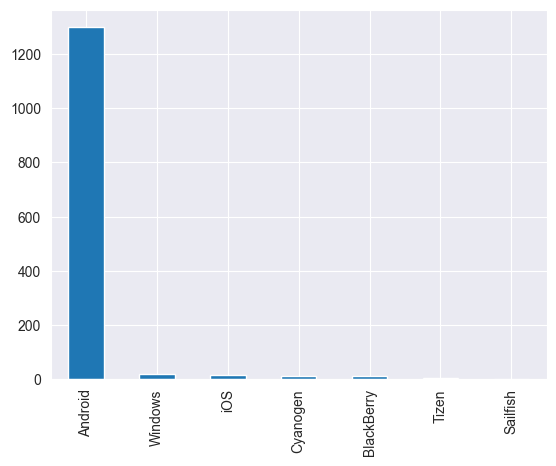

In [233]:
df['operating_system'].value_counts().plot(kind="bar");

# Phones by Brand
As evidenced by the plots, most phones in this dataset are manufactured by Intex, Samsung, Micromax, Lava and Panasonic.

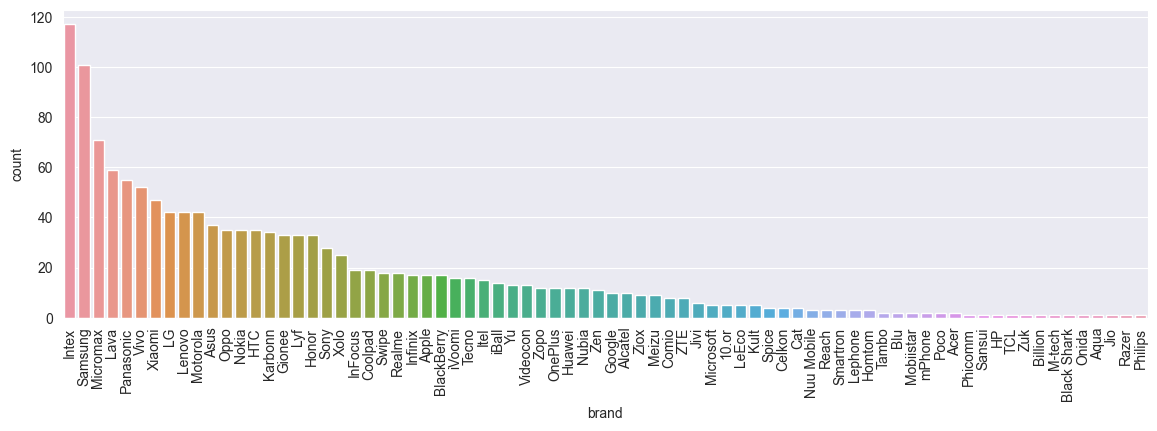

In [234]:
plt.figure(figsize=(14,4))

category_order = df.brand.value_counts().index

sns.countplot(df, x='brand', order=category_order)
plt.xticks(rotation=90);

# Price Distribution
As the target variable, it is extremely important to understand its distribution. In order to do this, we plot a Histogram with a Kernel Density Curve.

As evidenced below, the distribution is skewed to the right. There are some expensive phones that range from 800 - 2500`$`, but most are actually concentrated around the 0-500`$` mark.

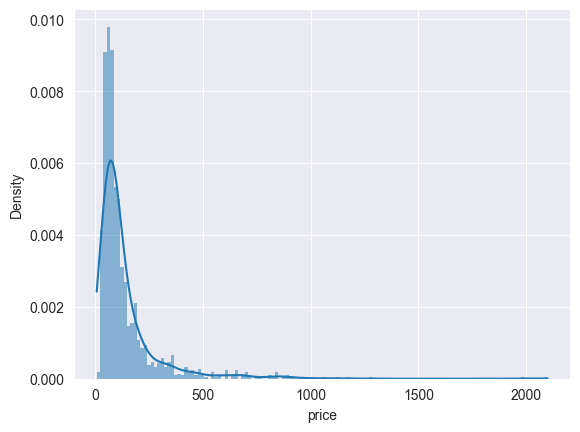

In [235]:
sns.histplot(df.price, stat='density', kde=True, linewidth=0);

## Log Transformation
In order to mitigate the skewness, we can try to log-transform the data so that the target variable approaches a normal distribution.

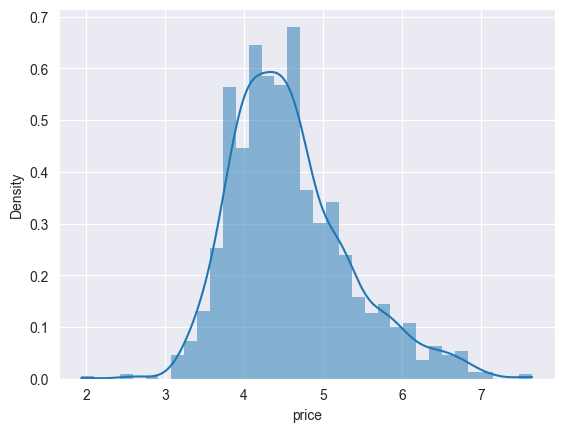

In [236]:
sns.histplot(np.log1p(df.price), stat='density', kde=True, linewidth=0);

## Feature Selection and Train-Test Split
Separating the features from the target variable and doing the train-test-validation split.

In [237]:
# Removing the `names` and `model` features, which are redundant and unnecesary, only useful to query the data
features = ['brand', 'battery_capacity', 'screen_size',
       'touch_screen', 'resolution_x', 'resolution_y', 'processor', 'ram',
       'internal_storage', 'rear_camera', 'front_camera', 'operating_system',
       'wi_fi', 'bluetooth', 'gps', 'number_of_sims', '3g', '4g_lte']
target = ['price']

In [238]:
# Setting a seed (random state)
custom_seed = 287

df_full_train, df_test = train_test_split(df[features + target], test_size=0.2, shuffle=True, random_state=custom_seed)
df_train, df_validation = train_test_split(df_full_train, test_size=0.25, shuffle=True, random_state=custom_seed)

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [239]:
# Printing the number of records in each dataset
print(f"Full: {len(df)}")
print(f"Full Train Set : {len(df_full_train)}")
print(f"Training Set : {len(df_train)}")
print(f"Validation Set: {len(df_validation)}")
print(f"Test Set : {len(df_test)}")

Full: 1359
Full Train Set : 1087
Training Set : 815
Validation Set: 272
Test Set : 272


In [240]:
#Applying a Log Transformation to the Target Variable
y_train = np.log1p(df_train[target].values)
y_validation = np.log1p(df_validation[target].values)
y_test = np.log1p(df_test[target].values)

In [241]:
# Removing the target variable
del df_train[target[0]], df_validation[target[0]], df_test[target[0]]

## Baseline Model
A baseline model is essentially a simple model that acts as a reference in a machine learning project. Its main function is to contextualize the results of trained models. Baseline models usually lack complexity and may have little predictive power.

In this case, we use a Linear Regression Model with default parameters as a Baseline.

In [242]:
def evaluate_model(train_data, validation_data, model, selected_features):
    dict_vectorizer = DictVectorizer(sparse=False)
    dtrain = train_data[selected_features].to_dict(orient='records')
    x_train = dict_vectorizer.fit_transform(dtrain)
    model.fit(x_train, y_train)

    dval = validation_data[selected_features].to_dict(orient='records')
    x_val = dict_vectorizer.transform(dval)
    y_pred = model.predict(x_val)
    return np.sqrt(mean_squared_error(y_validation, y_pred))

In [243]:
# Evaluating the baseline model
baseline_model = LinearRegression()
baseline_model.rmse = evaluate_model(df_train, df_validation, baseline_model, features)
print(round(baseline_model.rmse, 5))

7756.21541


In [244]:
columns = ['model', 'rmse']
models = [("Baseline Linear Regression", baseline_model.rmse)]
models

[('Baseline Linear Regression', 7756.215405299715)]

# Decision Trees

Now that we have a quantifiable Baseline Model, with its RMSE, we can try to tune the parameters so as to minimize the RMSE, as well as compare it with other models.

We proceed to train a Decision Stump, a Decision Tree with max depth of 1

In [245]:
decision_stump = DecisionTreeRegressor(max_depth=1, random_state=custom_seed)
decision_stump.rmse = evaluate_model(df_train, df_validation, decision_stump, features)
print(round(decision_stump.rmse, 5))

0.62038


In [246]:
models.append(("Decision Stump", decision_stump.rmse))
models

[('Baseline Linear Regression', 7756.215405299715),
 ('Decision Stump', 0.6203796205666162)]

Now, we fit a Decision Tree Regressor with default `max_depth` and `min_samples_leaf` parameters.

In [247]:
decision_tree_model = DecisionTreeRegressor(random_state=custom_seed)
decision_tree_model.rmse = evaluate_model(df_train, df_validation, decision_tree_model, features)
print(round(decision_tree_model.rmse, 5))

0.51709


In [248]:
models.append(("Decision Tree Regressor", decision_tree_model.rmse))
models

[('Baseline Linear Regression', 7756.215405299715),
 ('Decision Stump', 0.6203796205666162),
 ('Decision Tree Regressor', 0.5170882625542527)]

In [249]:
dict_vectorizer = DictVectorizer(sparse=False)
dtrain = df_train[features].to_dict(orient='records')
x_train = dict_vectorizer.fit_transform(dtrain)
baseline_model.fit(x_train, y_train)

dval = df_validation[features].to_dict(orient='records')
x_val = dict_vectorizer.transform(dval)
y_pred = baseline_model.predict(x_val)

## Tuning the model

In [250]:
tree_model = DecisionTreeRegressor()

df_train_copy = df_train.copy()
df_val_copy = df_validation.copy()
dtrain_copy = df_train_copy.to_dict(orient='records')

dict_vectorizer = DictVectorizer(sparse=False)
x_train_copy = dict_vectorizer.fit_transform(dtrain_copy)

In [251]:
# Setting up the Grid Search

max_depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
min_samples_leafs = [1, 2, 5, 10, 15, 20, 100, 200, 500]
max_features = [1.0, "sqrt", "log2", None]
criteria = ["squared_error", "friedman_mse", "absolute_error", "poisson"]

grid = dict(max_depth=max_depths, min_samples_leaf=min_samples_leafs, max_features=max_features, criterion=criteria)
cv = RepeatedKFold(n_repeats=3, random_state=5)
grid_search = GridSearchCV(tree_model, param_grid=grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
gridr = grid_search.fit(x_train_copy, y_train)


In [252]:

mean_scores = gridr.cv_results_['mean_test_score']
std_scores = gridr.cv_results_['std_test_score']
params = gridr.cv_results_['params']

columns_grid = ["mean score", "std score", "params"]
grid_results = []

for mean, std, param in zip(mean_scores, std_scores, params):
    grid_results.append((mean, std, param))
grid_results_df = pd.DataFrame(grid_results, columns=columns_grid)

In [253]:
grid_results_df.sort_values(by='mean score', ascending=False)

,mean score,std score,params
1292,-0.482495,0.040008,"{'criterion': 'poisson', 'max_depth': 6, 'max_..."
1265,-0.482495,0.040008,"{'criterion': 'poisson', 'max_depth': 6, 'max_..."
1364,-0.483546,0.040612,"{'criterion': 'poisson', 'max_depth': 15, 'max..."
1400,-0.483546,0.040612,"{'criterion': 'poisson', 'max_depth': 20, 'max..."
1373,-0.483546,0.040612,"{'criterion': 'poisson', 'max_depth': 20, 'max..."
...,...,...,...
791,-0.760339,0.054219,"{'criterion': 'absolute_error', 'max_depth': 2..."
800,-0.760339,0.054219,"{'criterion': 'absolute_error', 'max_depth': 3..."
980,-0.760339,0.054219,"{'criterion': 'absolute_error', 'max_depth': 1..."
809,-0.760339,0.054219,"{'criterion': 'absolute_error', 'max_depth': 3..."


In [254]:
grid_results_df.iloc[1265]['params']

{'criterion': 'poisson',
 'max_depth': 6,
 'max_features': 1.0,
 'min_samples_leaf': 20}

In [255]:
tuned_decision_tree = DecisionTreeRegressor(criterion='poisson', max_depth=6, max_features=1.0, min_samples_leaf=20)
tuned_decision_tree.rmse = evaluate_model(df_train_copy, df_val_copy, tuned_decision_tree, features)
print(tuned_decision_tree.rmse)

0.505389148710412


In [256]:
models.append(("Tuned Decision Tree Regressor", tuned_decision_tree.rmse))
models

[('Baseline Linear Regression', 7756.215405299715),
 ('Decision Stump', 0.6203796205666162),
 ('Decision Tree Regressor', 0.5170882625542527),
 ('Tuned Decision Tree Regressor', 0.505389148710412)]

# XGBoost

In [257]:
dv = DictVectorizer(sparse=False)

dict_train = df_train.to_dict(orient='records')
x_train = dv.fit_transform(dict_train)
features = dv.get_feature_names()
dtrain = xgb.DMatrix(x_train, label=y_train)

dict_val = df_validation.to_dict(orient='records')
x_val = dv.transform(dict_val)
dval = xgb.DMatrix(x_val, label=y_validation)

xgboost_seed = 20
xgb_params = {'seed': xgboost_seed, 'eval_metric': 'rmse', 'n_jobs': -1}
xgboost_model = xgb.train(xgb_params, dtrain)

C:\Users\JonAreas\.virtualenvs\Phone-Price-Prediction-E2pVZFWk\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [258]:
y_pred = xgboost_model.predict(dval)
xgboost_model.rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
xgboost_model.rmse

0.47006492825230467

In [259]:
models.append(("XGBoost", xgboost_model.rmse))
models

[('Baseline Linear Regression', 7756.215405299715),
 ('Decision Stump', 0.6203796205666162),
 ('Decision Tree Regressor', 0.5170882625542527),
 ('Tuned Decision Tree Regressor', 0.505389148710412),
 ('XGBoost', 0.47006492825230467)]

## Comparing the Models
Here, we compare all of the models fitted, which include XGBoost, a Decision Tree Regressor with Hyperparameter Tuning, a Default Decision Tree Regressor, a Decision Stump and a Default Linear Regression Model.

In [260]:
models_df = pd.DataFrame(models, columns=['Model', 'RMSE'])
models_df.sort_values(by='RMSE', ascending=True)

,Model,RMSE
4,XGBoost,0.470065
3,Tuned Decision Tree Regressor,0.505389
2,Decision Tree Regressor,0.517088
1,Decision Stump,0.620380
0,Baseline Linear Regression,7756.215405


# BentoML
Finally, we save our model using BentoML

In [262]:
# BentoML
import bentoml
bentoml.xgboost.save_model("xgboost_phone_predictor", xgboost_model,
                           custom_objects={
                               "dictVectorizer":dv
                           },
                           signatures={
                               "predict": {
                                   "batchable":True,
                                   "batch_dim":0,
                               }
                           })

Model(tag="xgboost_phone_predictor:t5ymq4dbcw73dhfw", path="C:\Users\JonAreas\bentoml\models\xgboost_phone_predictor\t5ymq4dbcw73dhfw\")